# Introduction to Imbanced Classification

In this notebook, we will delve into the basic *whats* and *hows* of dealing with imbalanced data sets. As you progress in your data science career, you'll find that a good amount of machine learning problems in reality involve dataset imbalance. It goes without saying that the other issues you've been introduced to before (e.g., missing values, highly correlated features) are still part of the challenge--so, the techniques you've already learned (e.g., imputation, feature selection) remain relevant. The following discussion, however, only focuses on preprocessing techniques that deal with class imbalance--for conciseness.

<img src='imba.jpeg' width='700'>

## `auto-ML` vs Imbalanced data set

We first look at how our `auto-ML` performs in dealing with an imbalanced data set.

**Scenario:** Suppose that we are a data science team working with a clinical research group that is attempting at formulating new diagnostic procedures in detecting COVID-19. Ultimately, the pursuit of the study is to accurately diagnose patients who are infected of the virus. Secondary to this goal is to provide an alternative testing procedure that (1) costs cheaper and (2) generates results faster. Our team's role is to employ machine learning in making accurate diagnosis using only three variables that relate to biomarker measurements.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

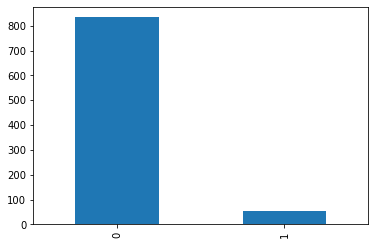

In [2]:
df = pd.read_csv('covid_clinical.csv')

df['class'].value_counts().plot.bar();

### Calculate the PCC

In [3]:
# write your code to do this below
pcc = ((df['class'].value_counts() / df.shape[0]) ** 2).sum()

print(f"PCC: {pcc:.2f}")

PCC: 0.88


### Run `sklearn` classifiers using their default settings

In the following code cells,we run our `auto-ML` using the default `sklearn` classifiers' settings, and our go-to metric: `accuracy`. At the minimum, the results are preferrably presented like below:

|Model Name|Train Acc|Val Acc|Run Time|
|--|--|--|--|
|SomeClassifier|xxx|xxx|xxx|
|AnotherClassifier|xxx|xxx|xxx|

We shall proceed as follows:
1. Split the data set into train-val and holdout sets, using 25% of the data as holdout, use `stratify=y`.
2. The train-val set will be used in your `auto-ML` to generate average train and validation accuracies, use your preferred cross validation procedure.
3. Discuss your observations regarding the performance of the models.

In [4]:
import time
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

# not advisable, but we do it for a cleaner report
# warnings regarding non-convergence of some classifiers used are muted
import warnings 
warnings.filterwarnings("ignore")

In [5]:
# initialize inputs: trainval and holdout set, use stratify=y, test_size=0.25
target_name = 'class'
X, y = df.drop(columns=[target_name] + ['pid']), df[target_name]

(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                           random_state=11, test_size=0.25, 
                                           stratify=y)

In [6]:
# initialize models with default hyperparamters
models_dict = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegressor': LogisticRegression(),
    'LinearSVM': SVC(kernel='linear'),
    'RBFSVM': SVC(),
    'GaussianNB': GaussianNB(),
    'RandomForestClassifier': RandomForestClassifier(random_state=11),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=11),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=11)   
}

In [7]:
# budget automl
skf = StratifiedKFold(n_splits=5)

res = {}

# log start time
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    train_scores = []
    val_scores = []
    
    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
        
        start_time = time.time() # for logging run times
        
        # fit
        model.fit(X_train, y_train)
        
        # default metric: accuracy
        train_score = model.score(X_train, y_train)
        val_score = model.score(X_val, y_val)
        
        end_time = time.time() # for logging run times
        
        train_scores.append(train_score)
        val_scores.append(val_score)
        
    res[model_name] = {
        'ave_train_acc':np.mean(train_scores) * 100,
        'ave_val_acc':np.mean(val_scores) * 100,
        'run_time': end_time - start_time
    }

# log end time
total_end = time.time()

elapsed = total_end - total_start
print(f"Report Generated in {elapsed:.2f} seconds")
display(pd.DataFrame(res).T)

100%|██████████| 8/8 [00:02<00:00,  3.65it/s]

Report Generated in 2.21 seconds


,ave_train_acc,ave_val_acc,run_time
KNeighborsClassifier,97.935505,97.749972,0.032931
LogisticRegressor,94.331913,94.295814,0.009832
LinearSVM,95.195517,94.895074,0.011212
RBFSVM,97.410106,97.449220,0.012153
GaussianNB,94.256937,93.995062,0.005826
RandomForestClassifier,99.962406,96.698463,0.225848
DecisionTreeClassifier,100.000000,95.346201,0.006534
GradientBoostingClassifier,100.000000,96.698463,0.124347


### Metrics for Imbalanced datasets

Considering our `PCC=0.88`, the current results show that our ML models perform well. But do they really? Being the the skeptics that we are, we go *beyond accuracy* and look deeper into the predictions in the following sections. To be brief, we arbitrarily choose to evaluate one classifier from our `automl`.

**Let's Do Some Counting**

As a next step in evaluating our model performance, we ask the following:

* **TP**: How many *infected* (covid-positive) persons can our ML model classify correctly?
* **TN**: How many *non-infected* (covid-negative) persons can our ML model classify correctly?
* **FP**: How many *non-infected* persons did our ML model tag as *positive*?
* **FN**: How many *infected* persons did our ML model tag as *negative*?

In [8]:
def get_confusion_matrix(y_true, y_pred, return_tuple=False):
    """Return confusion matrix from inputs of true and predicted values"""
    TP = ((y_pred == 1) & (y_true == 1)).sum()
    TN = ((y_pred == 0) & (y_true == 0)).sum()
    FP = ((y_pred == 1) & (y_true == 0)).sum()
    FN = ((y_pred == 0) & (y_true == 1)).sum()
    if return_tuple:
        return TN, FP, FN, TP
    return np.array([[TN, FP],
                     [FN, TP]])

In [9]:
# Show counting of TP, TN, FP, FN
model = GradientBoostingClassifier()
model.fit(X_trainval, y_trainval)

y_pred = model.predict(X_holdout)
y_true = y_holdout

get_confusion_matrix(y_true, y_pred)

array([[209,   0],
       [  6,   8]])

**Comparison with `AllNegativeClassifier`, `AllPositiveClassifier` and `PerfectClassifier`**

4it [00:00, 126.07it/s]


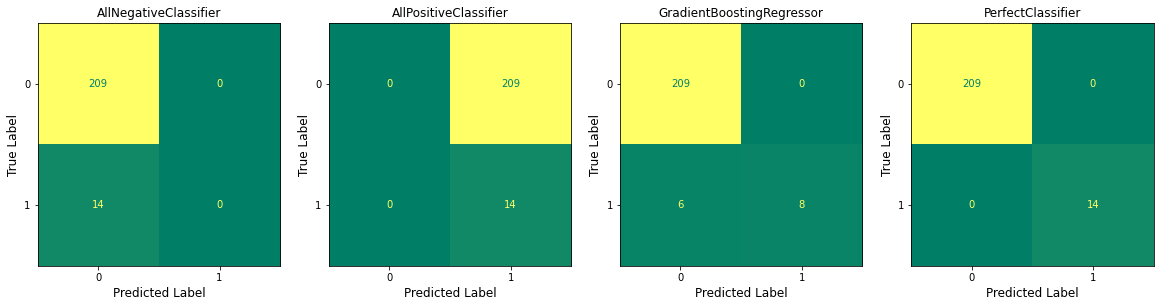

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

best_model = GradientBoostingClassifier()
best_model.fit(X_trainval, y_trainval)
y_pred = model.predict(X_holdout)

eval_dict = {
    'AllNegativeClassifier': np.zeros(y_holdout.shape),
    'AllPositiveClassifier' : np.ones(y_holdout.shape),
    'GradientBoostingRegressor': y_pred,
    'PerfectClassifier': y_holdout
}

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for index, (model_name, preds) in tqdm(enumerate(eval_dict.items())):
    ConfusionMatrixDisplay.from_predictions(y_holdout, preds, 
                                            ax=axes[index], cmap='summer',
                                            colorbar=False)
    axes[index].set_title(model_name, fontsize=12)
    axes[index].set_xlabel('Predicted Label', fontsize=12)
    axes[index].set_ylabel('True Label', fontsize=12)

**Unpacking the confusion**

The confusion matrix certainly provides a more informative evaluation of our model performance. In this section we use the confusion matrix to generate more meaningful metrics that are more apt for imbalanced classification problems. 

* ***Sensitivity/Recall/TPR***  - This metric is defined by the formula below. It tells us how well the positive (minority) class was predicted.

\begin{equation}
\mathrm{Recall/Sensitivity} = \frac{TP}{TP + FN}
\end{equation}

* ***Precision*** - This metric measures the fraction of correctly classified positive class and the number of samples classified as positive.

\begin{equation}
\mathrm{Precision} = \frac{TP}{TP + FP}
\end{equation}

* ***Specificity*** - This metric tells us how well the negative (majority) class was predicted.
 
\begin{equation}
\mathrm{Specificity} = \frac{TN}{FP + TN}
\end{equation}


* ***Geometric Mean*** - The $G_{mean}$ combines the *sensitivity (recall)* and the *specificity* into one score using the formula below:

\begin{equation}
\mathrm{G_{mean}} = \sqrt{\mathrm{Sensitivity} * \mathrm{Specificity}}
\end{equation}

* ***F-Beta Measure*** - This metric is a generalization of the F1 score that combines precision and recall into one metric. The beta parameter here controls which of precision or recall to favor.

\begin{equation}
F_{\beta}  = \frac{(1 + \beta^2)(\mathrm{Precision}*\mathrm{Recall})}{(\beta^2 * \mathrm{Precision}) + \mathrm{Recall}}
\end{equation}

**Learning Team Exercise** (10 mins)

In the google slides found here: [imba-ml exercise](https://docs.google.com/presentation/d/1uXrwW7yz4VBLxoZMbwtdtU2sf0z-OeK0FyB5EHU4L5Q/edit?usp=sharing)

1. Pick a slide for your LT and properly label it with your LT number.
2. List $3$ imbalanced classification problems likely to occur in reality (i.e., a potential business use case).
3. For each problem, discuss amongst yourselves, (a) what will be a suitable metric to measure a classifier's performance, and (b) what are the assumptions that guided your chioce of that metric. Summarize your discussion in the space provided.
4. You may choose to prettify (e.g., change a slide background color) but it is not necessary.

### Going Back to our COVID19 Diagnostics Problem

**What then could be a suitable metric and what are your assumptions that guide your choice of that metric?**

In [11]:
# define new metric
from sklearn.metrics import make_scorer, recall_score

def g_mean(y_true, y_pred):
    TN, FP, FN, TP = get_confusion_matrix(y_true, y_pred, return_tuple=True)
    
    specificity = TN / (FP + TN)
    sensitivity = recall_score(y_true, y_pred)
    score = np.sqrt(sensitivity * specificity)
    return score

# g_mean_scorer = make_scorer(g_mean)

In [12]:
# budget automl
skf = StratifiedKFold(n_splits=5)

res = {}

# log start time
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    train_scores = []
    val_scores = []
    
    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
        
        start_time = time.time() # for logging run times
        
        # fit
        model.fit(X_train, y_train)
        
        # default metric: accuracy
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)
        
        train_score = g_mean(y_train, train_preds)
        val_score = g_mean(y_val, val_preds)
        
        end_time = time.time() # for logging run times
        
        train_scores.append(train_score)
        val_scores.append(val_score)
        
    res[model_name] = {
        'ave_train_g_mean':np.mean(train_scores) * 100,
        'ave_val_g_mean':np.mean(val_scores) * 100,
        'run_time': end_time - start_time
    }
    
# log end time
total_end = time.time()

elapsed = total_end - total_start
print(f"Report Generated in {elapsed:.2f} seconds")
display(pd.DataFrame(res).T)

100%|██████████| 8/8 [00:02<00:00,  3.36it/s]

Report Generated in 2.38 seconds


,ave_train_g_mean,ave_val_g_mean,run_time
KNeighborsClassifier,81.518959,79.315652,0.040337
LogisticRegressor,27.237586,21.213203,0.014436
LinearSVM,44.709258,40.641294,0.015943
RBFSVM,76.073359,75.751713,0.016943
GaussianNB,22.439387,7.071068,0.010487
RandomForestClassifier,99.685020,65.385197,0.235579
DecisionTreeClassifier,100.000000,76.784078,0.011216
GradientBoostingClassifier,100.000000,66.644877,0.130019


4it [00:00, 174.57it/s]


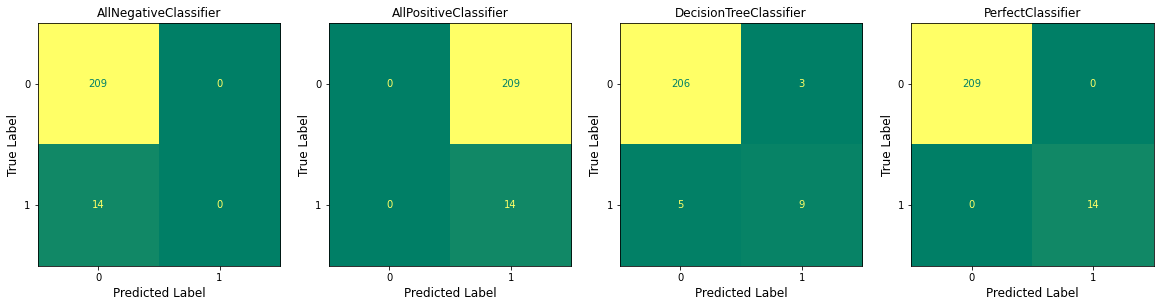

In [13]:
model_of_choice = 'DecisionTreeClassifier'
model = models_dict['DecisionTreeClassifier']
model.fit(X_trainval, y_trainval)
y_pred = model.predict(X_holdout)

eval_dict = {
    'AllNegativeClassifier': np.zeros(y_holdout.shape),
    'AllPositiveClassifier' : np.ones(y_holdout.shape),
     model_of_choice: y_pred,
    'PerfectClassifier': y_holdout
}

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for index, (model_name, preds) in tqdm(enumerate(eval_dict.items())):
    ConfusionMatrixDisplay.from_predictions(y_holdout, preds, 
                                            ax=axes[index], cmap='summer',
                                            colorbar=False)
    axes[index].set_title(model_name, fontsize=12)
    axes[index].set_xlabel('Predicted Label', fontsize=12)
    axes[index].set_ylabel('True Label', fontsize=12)

In [14]:
# compare with the PerfectClassifier
y_pred_perfect = eval_dict['PerfectClassifier']
y_pred_allnega = eval_dict['AllNegativeClassifier']
y_true = y_holdout

perfect = g_mean(y_true, y_pred_perfect)
allnega = g_mean(y_true, y_pred_allnega)

print("PerfectClassifier g-mean score:", perfect)
print("AllNegativeClassifier g-mean score:", allnega)

PerfectClassifier g-mean score: 1.0
AllNegativeClassifier g-mean score: 0.0


## Summary

* Accuracy isn't everything.
* As with any ML problem, we must first clearly define our objective which leads us in choosing a suitable metric for the evaluation of our classifier.

### Appendix


In [15]:
%%time
from sklearn.metrics import accuracy_score

new_res = {}
for model_name, model in tqdm(models_dict.items()):
    model.fit(X_trainval, y_trainval)
    y_pred = model.predict(X_holdout)
    
    new_res[model_name] = {
        'y_pred': y_pred,
        'y_true': y_holdout,
        'acc': accuracy_score(y_holdout, y_pred),
        'fitted_model': model
    }
print("Accuracies on holdout set")
display(pd.DataFrame(new_res).T['acc'] * 100)

100%|██████████| 8/8 [00:00<00:00, 18.83it/s]

Accuracies on holdout set


KNeighborsClassifier          97.309417
LogisticRegressor             94.170404
LinearSVM                     94.618834
RBFSVM                        97.309417
GaussianNB                    94.618834
RandomForestClassifier        96.412556
DecisionTreeClassifier        96.412556
GradientBoostingClassifier    97.309417
Name: acc, dtype: object

CPU times: user 435 ms, sys: 10 µs, total: 435 ms
Wall time: 432 ms


In [16]:
# AllNegativeClassifier
y_pred = np.zeros(y_holdout.shape) 
new_res['AllNegativeClassifier'] = {
    'y_pred': y_pred,
    'y_true': y_holdout,
    'acc': accuracy_score(y_holdout, y_pred)
}

print(f"AllNegativeClassifier Accuracy: {new_res['AllNegativeClassifier']['acc']:.2f}")

AllNegativeClassifier Accuracy: 0.94


9it [00:00, 108.22it/s]


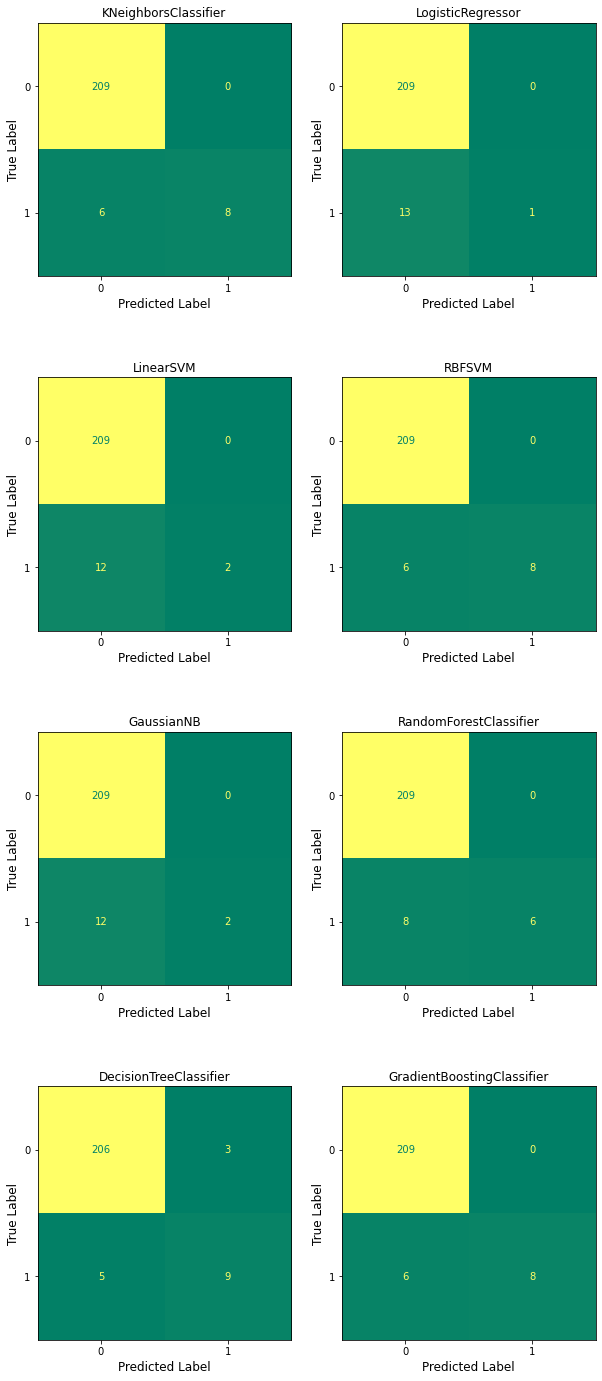

In [17]:
from sklearn.metrics import plot_confusion_matrix

fig, axes = plt.subplots(4, 2, figsize=(10, 25))
flat_axes = axes.flatten()
for index, (model_name, results) in tqdm(enumerate(new_res.items())):
    if model_name=='AllNegativeClassifier':
        continue
    plot_confusion_matrix(results['fitted_model'],
                          X_holdout, y_holdout, ax=flat_axes[index],
                          cmap='summer', colorbar=False)
    flat_axes[index].set_title(model_name, fontsize=12)
    flat_axes[index].set_xlabel('Predicted Label', fontsize=12)
    flat_axes[index].set_ylabel('True Label', fontsize=12)

## End